# Loan Status Prediction

Credit Risk Models are one of the most successful applications of data science. The problem can be put as the prediction of how much financially-reliable a person is, given a set of information(data).
The implementation of such predictive models has raised many discussions concerning privacy, racial profiling etc.

We will be using an anonymized dataset that consists of a set of attributes for a bank's users.
You may find the dataset [here](https://www.kaggle.com/zaurbegiev/my-dataset).

Let us first install sklearn and numpy libraries:

In [16]:
!pip3 install scikit-learn numpy matplotlib pandas

Now let's import all the required libraries.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.impute import SimpleImputer as Imputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from warnings import filterwarnings
filterwarnings('ignore')

## Load Raw Data

In [18]:
df = pd.read_csv("credit_train.csv")

In [19]:
# df = df[:10000]

In [20]:
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       100000 non-null  object 
 1   Customer ID                   100000 non-null  object 
 2   Loan Status                   100000 non-null  object 
 3   Current Loan Amount           100000 non-null  float64
 4   Term                          100000 non-null  object 
 5   Credit Score                  80846 non-null   float64
 6   Annual Income                 80846 non-null   float64
 7   Years in current job          95778 non-null   object 
 8   Home Ownership                100000 non-null  object 
 9   Purpose                       100000 non-null  object 
 10  Monthly Debt                  100000 non-null  float64
 11  Years of Credit History       100000 non-null  float64
 12  Months since last delinquent  46859 non-null

## Data Preprocessing

#### Feature Selection

In [22]:
cols_to_remove = ['Loan ID','Customer ID']
data = df.drop(cols_to_remove, axis=1)


#### Data Cleaning

In [23]:
#Imputation strategy: Replace Non-existing values with the respective column's average
cols_to_clean =['Current Loan Amount','Credit Score','Annual Income','Years of Credit History',
        'Months since last delinquent','Number of Open Accounts','Number of Credit Problems',
       'Current Credit Balance','Maximum Open Credit','Bankruptcies','Tax Liens']

imputer = Imputer()
data[cols_to_clean] = imputer.fit_transform(data[cols_to_clean])
data[cols_to_clean] = data[cols_to_clean].astype(int)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan Status                   100000 non-null  object 
 1   Current Loan Amount           100514 non-null  int64  
 2   Term                          100000 non-null  object 
 3   Credit Score                  100514 non-null  int64  
 4   Annual Income                 100514 non-null  int64  
 5   Years in current job          95778 non-null   object 
 6   Home Ownership                100000 non-null  object 
 7   Purpose                       100000 non-null  object 
 8   Monthly Debt                  100000 non-null  float64
 9   Years of Credit History       100514 non-null  int64  
 10  Months since last delinquent  100514 non-null  int64  
 11  Number of Open Accounts       100514 non-null  int64  
 12  Number of Credit Problems     100514 non-nul

In [25]:
#Remove rows that still contain one or more NaN values
data=data.dropna()

#### Feature Engineering

In [26]:
#Convert our target attribute to numerical values
y = []
for i in data['Loan Status']:
    if i == 'Fully Paid':
        y.append(1)
    else:
        y.append(0)

data = data.drop('Loan Status', axis=1)

In [27]:
# Convert categorical attributes to numerical values
print(data.info())
data = pd.get_dummies(data)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 95778 entries, 0 to 99998
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Current Loan Amount           95778 non-null  int64  
 1   Term                          95778 non-null  object 
 2   Credit Score                  95778 non-null  int64  
 3   Annual Income                 95778 non-null  int64  
 4   Years in current job          95778 non-null  object 
 5   Home Ownership                95778 non-null  object 
 6   Purpose                       95778 non-null  object 
 7   Monthly Debt                  95778 non-null  float64
 8   Years of Credit History       95778 non-null  int64  
 9   Months since last delinquent  95778 non-null  int64  
 10  Number of Open Accounts       95778 non-null  int64  
 11  Number of Credit Problems     95778 non-null  int64  
 12  Current Credit Balance        95778 non-null  int64  
 13  Maximu

In [28]:
# Data Normalization -- Version one
# All variables will have a mean zero and variance/standard deviation of 1
xMean = np.mean(data, axis=0)
xDev = np.std(data, axis=0)
xNorm = (data - xMean) / xDev

In [29]:
xMean

Current Loan Amount               1.182252e+07
Credit Score                      1.072732e+03
Annual Income                     1.395093e+06
Monthly Debt                      1.870294e+04
Years of Credit History           1.756989e+01
Months since last delinquent      3.438006e+01
Number of Open Accounts           1.118261e+01
Number of Credit Problems         1.623233e-01
Current Credit Balance            2.969464e+05
Maximum Open Credit               7.640170e+05
Bankruptcies                      1.128025e-01
Tax Liens                         2.839901e-02
Term_Long Term                    2.829564e-01
Term_Short Term                   7.170436e-01
Years in current job_1 year       6.744764e-02
Years in current job_10+ years    3.249285e-01
Years in current job_2 years      9.536637e-02
Years in current job_3 years      8.529099e-02
Years in current job_4 years      6.413790e-02
Years in current job_5 years      7.086178e-02
Years in current job_6 years      5.936645e-02
Years in curr

In [30]:
# Data Normalization -- Version two
# All features are scaled within a given range (0.0-1.0 by default)

x = data.values #returns numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
xMinMax = pd.DataFrame(x_scaled)
xNoNorm = data

In [31]:
xNorm

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,...,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_major_purchase,Purpose_moving,Purpose_other,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding
0,-0.357163,-0.275813,-0.231181,-1.102757,-0.083655,-0.025223,-1.032353,1.766006,-0.181761,-0.040651,...,-0.104978,-0.183257,-0.075789,-0.059067,-0.038123,-0.251364,-0.010219,-0.053954,-0.03151,-0.034521
1,-0.362911,0.002478,-0.017082,1.193086,0.503508,-1.750770,4.744319,-0.342213,-0.177039,0.010157,...,-0.104978,-0.183257,-0.075789,-0.059067,-0.038123,-0.251364,-0.010219,-0.053954,-0.03151,-0.034521
2,2.768168,-0.251548,0.849964,0.858254,-0.524027,-0.357059,1.357994,1.766006,0.002775,-0.001630,...,-0.104978,-0.183257,-0.075789,-0.059067,-0.038123,-0.251364,-0.010219,-0.053954,-0.03151,-0.034521
3,-0.360232,-0.266714,-0.597397,-0.814386,-0.817608,-0.025223,-0.434766,-0.342213,-0.107374,-0.044138,...,-0.104978,-0.183257,-0.075789,-0.059067,-0.038123,-0.251364,-0.010219,-0.053954,-0.03151,-0.034521
4,-0.365614,0.002478,-0.017082,0.158344,-1.698352,-0.025223,0.760407,-0.342213,-0.114958,-0.039430,...,-0.104978,-0.183257,-0.075789,-0.059067,-0.038123,-0.251364,-0.010219,-0.053954,-0.03151,-0.034521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-0.364535,-0.268230,-0.621328,-1.224340,-0.083655,-1.087098,-1.032353,-0.342213,-0.783786,-0.059098,...,-0.104978,5.456830,-0.075789,-0.059067,-0.038123,-0.251364,-0.010219,-0.053954,-0.03151,-0.034521
99995,-0.366529,-0.263681,-0.934125,-1.348999,0.650299,-0.025223,-1.231549,-0.342213,-0.658719,-0.012346,...,-0.104978,-0.183257,-0.075789,-0.059067,-0.038123,3.978288,-0.010219,-0.053954,-0.03151,-0.034521
99996,2.768168,-0.258373,-0.107340,-0.457340,-1.257980,-0.887996,2.154776,-0.342213,-0.380410,-0.029825,...,-0.104978,-0.183257,-0.075789,-0.059067,-0.038123,-0.251364,-0.010219,-0.053954,-0.03151,-0.034521
99997,-0.367908,-0.250790,-0.248396,-0.930999,0.063136,-1.087098,0.162821,1.766006,-0.495380,-0.026510,...,-0.104978,-0.183257,-0.075789,-0.059067,-0.038123,-0.251364,-0.010219,-0.053954,-0.03151,-0.034521


Next we will see how we get different predictive performances by using the raw features vs the two other feature normalization techniques.

In [32]:
data_versions = []
# Define three cases we will study
for x in [xNorm, xMinMax, xNoNorm]:
    version = {}
    version['x_train'], version['x_test'], version['y_train'], version['y_test'] = train_test_split(x, y, test_size= 0.25, random_state=13)
    data_versions.append(version)

## Model Training and Evaluation

In [33]:
# Initialize the classifiers that we will be testing
clf = KNeighborsClassifier(n_neighbors=2)

for i, data_version in enumerate(data_versions):
    print("Evaluating the model with data from the version #{}".format(i+1))
    #train model with train data
    clf.fit(X=data_version['x_train'], y=data_version['y_train'])
        
    #predict test data
    predictions = clf.predict(X=data_version['x_test'])
        
    #calculate the accuracy
    accuracy = accuracy_score(data_version['y_test'], predictions)

    print("\t Classifier  achieved {} accuracy on test data.".format(100*accuracy))

Evaluating the model with data from the version #1
	 Classifier  achieved 67.1664230528294 accuracy on test data.
Evaluating the model with data from the version #2
	 Classifier  achieved 67.70515765295468 accuracy on test data.
Evaluating the model with data from the version #3
	 Classifier  achieved 61.95865525161829 accuracy on test data.


### TODO: 
Follow a similar approach with the one described in the previous cell.
<br>Evaluate the performance of Logistic Regression and Random Forest classifiers. 
<br>Try to find a set of parameters that work the best for each classifier.

In [34]:
# Using: Logistic Regression Classifier

In [35]:
# Initialize the classifiers that we will be testing
clf = LogisticRegression()

for i, data_version in enumerate(data_versions):
    print("Evaluating the model with data from the version #{}".format(i+1))
    #train model with train data
    clf.fit(X=data_version['x_train'], y=data_version['y_train'])
        
    #predict test data
    predictions = clf.predict(X=data_version['x_test'])
        
    #calculate the accuracy
    accuracy = accuracy_score(data_version['y_test'], predictions)

    print("\t Classifier  achieved {} accuracy on test data.".format(100*accuracy))

Evaluating the model with data from the version #1
	 Classifier  achieved 82.02965128419294 accuracy on test data.
Evaluating the model with data from the version #2
	 Classifier  achieved 82.0505324702443 accuracy on test data.
Evaluating the model with data from the version #3
	 Classifier  achieved 81.75819586552517 accuracy on test data.


In [36]:
# Using: Random Forest Classifier

In [37]:
# Initialize the classifiers that we will be testing
clf = RandomForestClassifier(n_estimators=100, max_depth=8)

for i, data_version in enumerate(data_versions):
    print("Evaluating the model with data from the version #{}".format(i+1))
    #train model with train data
    clf.fit(X=data_version['x_train'], y=data_version['y_train'])
        
    #predict test data
    predictions = clf.predict(X=data_version['x_test'])
        
    #calculate the accuracy
    accuracy = accuracy_score(data_version['y_test'], predictions)

    print("\t Classifier  achieved {} accuracy on test data.".format(100*accuracy))

Evaluating the model with data from the version #1
	 Classifier  achieved 82.04217999582376 accuracy on test data.
Evaluating the model with data from the version #2
	 Classifier  achieved 82.0505324702443 accuracy on test data.
Evaluating the model with data from the version #3
	 Classifier  achieved 82.04635623303403 accuracy on test data.


### Evaluation of the features that have contributed to the result

Let's see for the latest model, which features, columns of X train, have contributed most to the result of the learning of the classifier. It can be done by utilizing `feature_importances` of the classifier. We then take only the importances where the value is bigger than 0.001, to make the plot look nicer with only the most important features. We see that credit score affects the most in the classifier, then the current loan amount, term_short term and annual income. 

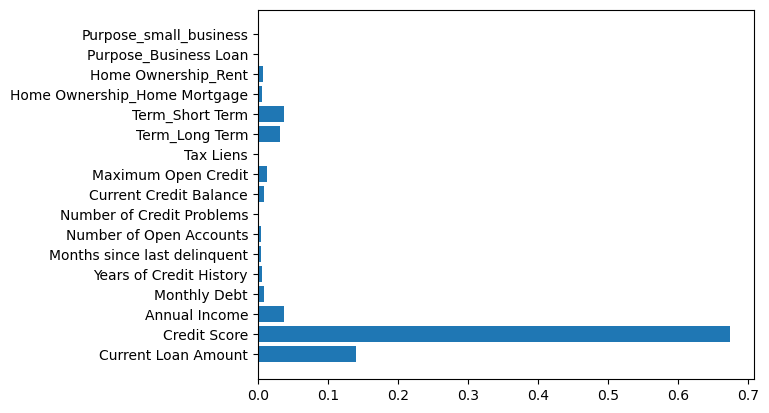

In [38]:
importances = clf.feature_importances_
indexes = [i for i in range(len(importances)) if importances[i] > 0.001]
importances_indexes = list(map(lambda i: importances[i], indexes))
columns_indexes = list(map(lambda i: list(data_version['x_train'].columns)[i], indexes))

plt.barh(columns_indexes, importances_indexes)
plt.show()

### Ethical considerations

When doing different kinds of classifiers, it is very important to know, which features affect to the end result and how much. In our case, we don't know what the feature `Credit score` includes: for example, is there included any personal attributes, such as age, gender or even if the person belongs to a minority? A usual way to make sure that the algorithm is not discriminating any groups is to take a close look to the data before training and remove sensitive attributes, such as gender, possibly age etc. 

#### Evaluate the performance of the best combination, using the k-fold cross-validation approach

In [39]:
# Implement Cross Validation using Logistic Regression classifier
# Using xMinMax dataframe

X_data = xMinMax

clf = LogisticRegression(penalty='l2', dual=True, tol=0.0001, C=2.0, solver='liblinear', max_iter=100, multi_class='deprecated', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

# 5 fold cross validation
scores = cross_val_score(clf, X_data, y, verbose=1, cv=5)
print(scores)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

[0.82355398 0.81822928 0.82157027 0.82276168 0.82317933]
Accuracy: 0.822 (+/- 0.004)


In [40]:
# Implement Cross Validation using RandomForestClassifier classifier
# Using xMinMax dataframe

X_data = xMinMax

clf = RandomForestClassifier()

# 5 fold cross validation
scores = cross_val_score(clf, X_data, y, verbose=1, cv=5)
print(scores)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

[0.82605972 0.82052621 0.82235331 0.82490211 0.82328374]
Accuracy: 0.823 (+/- 0.004)


In [ ]:
# Implement Cross Validation using GradientBoostingClassifier classifier
# Using xMinMax dataframe

X_data = xMinMax

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)

# 5 fold cross validation
scores = cross_val_score(clf, X_data, y, verbose=1, cv=5)
print(scores)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

In [ ]:
from sklearn.neural_network import MLPClassifier

# Implement Cross Validation using Logistic Regression classifier
# Using xMinMax dataframe

X_data = xMinMax

clf = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500)

# 5 fold cross validation
scores = cross_val_score(clf, X_data, y, verbose=1, cv=5)
print(scores)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

In [ ]:
from sklearn.svm import SVC

# Implement Cross Validation using SVC classifier
# Using xMinMax dataframe

X_data = xMinMax

clf = SVC(kernel='rbf', C=1.0, gamma='scale')

# 5 fold cross validation
scores = cross_val_score(clf, X_data, y, verbose=1, cv=5)
print(scores)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

In [ ]:
# Implement Cross Validation using Logistic Regression classifier
# Using xMinMax dataframe

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

X_data = xMinMax

# Define hyperparameters for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],  # Optimization solvers
    'max_iter': [100, 200, 500]  # Number of iterations
}

# Grid Search for best hyperparameters
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_data, y)

clf = grid.best_estimator_

# 5 fold cross validation
scores = cross_val_score(clf, X_data, y, verbose=1, cv=5)
print(scores)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))